# Исследование метода Рунге-Кутты

Реализация метода Рунге-Кутты (см. https://github.com/matveevk/Differential-Equations-Solver).

In [1]:
# lines to import library
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# other imports
from dif_solver import DifSolver
import matplotlib.pyplot as plt
import math
from math import *
import numpy as np

In [2]:
# загатавливаем функцию для демонстрации решения
def draw(xs, ys, ys_true, title='Решение'):
    plt.plot(xs, ys, label='Результат')
    plt.plot(xs, ys_true, label='Реальная функция')
    plt.legend()
    plt.title(title)
    plt.show()
    # сравниваем с истиной
    print('Среднее отклонение результата от истины:', 
          np.average(abs(ys - ys_true)))
    print('Последнее отклонение результата от истины:', abs(ys[-1] - ys_true[-1]))
    print('Среднее относительное отклонение результата от истины:', 
         np.average(abs((ys - ys_true) / ys_true)))
    print('Последнее отклонение результата от истины:', abs(ys[-1] - ys_true[-1]) / abs(ys_true[-1]))

## Постановка задачи

В модуле `dif_solver` реализован класс `DifSolver`, решающий задачу Коши методом Рунге-Кутты.

Пусть имеется задача Коши: дано обыкновенное дифференциальное уравнение
$$y'(x) = f(x, y),$$
вместе с начальным условием $$y(x_0) = y_0.$$
Надо найти $y(x)$.

### Метод Эйлера

Искомую функцию $y(x)$ в точках $x_0, x_1, \ldots$ (с малым шагом $h$) можно оценить следующим образом:

$$y_n = y_{n-1} + h\cdot f(x_{n-1}, y_{n-1}).$$

По сути, каждое следующее значение пересчитывается как предыдущее с соответствующим сдвигом на производную (прирост).

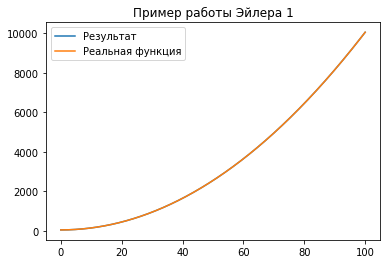

Среднее отклонение результата от истины: 0.24998749999927772
Последнее отклонение результата от истины: 0.4999749999951746
Среднее относительное отклонение результата от истины: 0.00013258137682666254
Последнее отклонение результата от истины: 4.975370671224319e-05


In [4]:
euler = DifSolver("y' = 2 * x", "y(0) = 50")
xs, ys = euler.solve(method='EULER', step=0.005, breadth=100)

ys_true = np.array(list(map(lambda x: x**2+50, xs)))
draw(xs, ys, ys_true, 'Пример работы Эйлера 1')

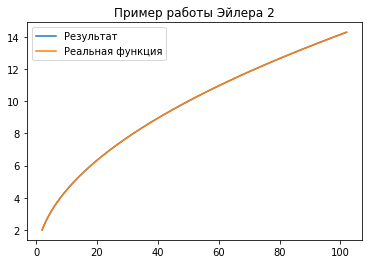

Среднее отклонение результата от истины: 0.00079012956619239
Последнее отклонение результата от истины: 0.0006884387418697457
Среднее относительное отклонение результата от истины: 9.667231592080799e-05
Последнее отклонение результата от истины: 4.820271590182275e-05


In [6]:
euler = DifSolver("y' = 1/y", "y(2) = 2")
xs, ys = euler.solve(method='EULER', step=0.01, breadth=100)

ys_true = np.array(list(map(lambda x: sqrt(2 * x), xs)))
draw(xs, ys, ys_true, 'Пример работы Эйлера 2')

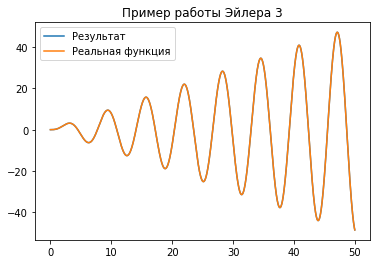

Среднее отклонение результата от истины: 0.00802484167758076
Последнее отклонение результата от истины: 0.006587358110905939
Среднее относительное отклонение результата от истины: nan
Последнее отклонение результата от истины: 0.00013582872425399505


C:\Users\uraga\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


In [8]:
euler = DifSolver("y' = t * sin(t)", "y(0) = 0")
xs, ys = euler.solve(method='EULER', step=0.001, breadth=50)

ys_true = list(map(lambda x: sin(x)-cos(x)*x, xs))
draw(xs, ys, ys_true, 'Пример работы Эйлера 3')

Можно заметить, что отклонение уменьшается линейно с увеличением $h$. Это поясняется теоретически. По определению производной, при малых $h$

$$y(x_{n}) = y(x_{n-1}+h) = y(x_{n-1}) + h\cdot y'(x_{n-1}) + O(h^2);$$
$$y(x_{n}) = y_{n-1} + h\cdot f(x_{n-1}, y_{n-1}) + O(h^2);$$
$$y(x_n) - y_{n}= O(h^2).$$

Учитывая то, что на каждом шаге ошибка $O(h^2)$, а всего шагов $\frac{breadth}{h} = O(\frac1{h})$, получаем накопительное отклонение $O(h)$.

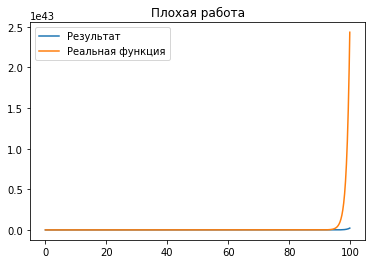

Среднее отклонение результата от истины: 2.5312516799027334e+41
Последнее отклонение результата от истины: 2.4098550383608946e+43
Среднее относительное отклонение результата от истины: 0.788235625088073
Последнее отклонение результата от истины: 0.9907684690315057


In [9]:
euler = DifSolver('dy/dx = y', 'y(0) = 1')
xs, ys = euler.solve(method='EULER', visualize=False, step=0.1, breadth=100)

ys_true = np.array(list(map(lambda x: math.exp(x), xs)))
draw(xs, ys, ys_true, 'Плохая работа')

Как видно, в последнем примере проявляется проблема метода при работе с функциями, производная которых резко меняется. В таких случаях $h$, будучи фиксированным, в какой-то момент слишком большой, чтобы давать точный результат, и он в итоге накапливается в большую ошибку. Так это случилось и для искомой функции $y(x) = e^x$.

Можно улучшить метод, добавляя операции пересчёта, которые избавят нас от такой проблемы (в некотором смысле отложат её эффект на более "поздние" моменты времени).

### Улучшенный метод Эйлера

Теперь будем пересчитывать значение $y_n$, аппроксимируя его усреднённым значением производной.

$$y_n = y_{n-1} + h\cdot \frac{k_1 + k_2}{2},$$

где

$k_1 = f(x_{n-1}, y_{n-1})$,

$k_2 = f(x_{n}, y_{n-1} + h\cdot k_1)$.

По сути здесь вместо того, чтобы добавлять значение $k_1$, которое мы получили бы в простом методе Эйлера, мы добавляем среднее значение из него и производной в той точке, которую предполагали верной в методе Эйлера. Такой способ уточняет результат и является **методом Рунге-Кутты второго порядка**, также известный как метод Хойна.

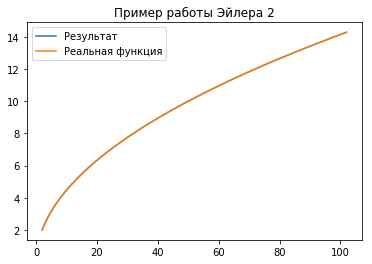

Среднее отклонение результата от истины: 2.2736795890487827e-10
Последнее отклонение результата от истины: 1.3704770651656872e-10
Среднее относительное отклонение результата от истины: 3.3581459459041416e-11
Последнее отклонение результата от истины: 9.595729090249876e-12


In [11]:
euler = DifSolver("y' = 1/y", "y(2) = 2")
xs, ys = euler.solve(method='MEULER', step=0.01, breadth=100)

ys_true = np.array(list(map(lambda x: sqrt(2 * x), xs)))
draw(xs, ys, ys_true, 'Пример работы Эйлера 2')

Это метод второго порядка, потому что ошибка квадратична по $h$. Действительно, раскладывая производную, получаем
    
$$f(x_n, y_{n-1} + hk_1) = f(x_{n-1}, y_{n-1}) + hf'_x(x_{n-1}, y_{n-1}) + hk_1f'_y(x_{n-1}, y_{n-1}) + O(h^2),$$
откуда
$$y_n = y_{n-1} + hf(x_{n-1}, y_{n-1}) + \frac{h^2}2f'_x(x_{n-1}, y_{n-1}) + \frac{h^2}2 f(x_{n-1}, y_{n-1})f'_y(x_{n-1}, y_{n-1}) + O(h^3).$$
В то же время
$$y(x_n) = y_{n-1} + hf(x_{n-1}, y_{n-1}) + \frac{h^2}2f'(x_{n-1}, y_{n-1}) + O(h^3) = $$
$$= y_{n-1} + hf(x_{n-1}, y_{n-1}) + \frac{h^2}2\left(f'_x(x_{n-1}, y_{n-1}) + f'_y(x_{n-1}, y_{n-1})f(x_{n-1}, y_{n-1})\right) + O(h^3).$$
Сопоставляя результаты, имеем 
$$y(x_n) - y_n = O(h^3).$$
Аналогично методу Эйлера, шагов всего $\frac{breadth}{h} = O(\frac1{h})$, поэтому накопленная ошибка $O(h^2)$.

Такой принцип обобщается на большие размерности.

### Метод Рунге-Кутты

Приближение искомой функции $y(x)$ можно вычислить следующим методом (**метод Рунге Кутты порядка 4**).

При заданном (малом) шаге $h > 0$ и взятой последовательности $x_n = x_0 + h\cdot n$, оценить соответствующие значения $y_n$ предлагается по следующей формуле:
$$y_n = y_{n-1} + h\cdot\dfrac{k_1 + 2k_2 + 2k_3 + k_4}{6},$$
где 

$k_1 = f(x_{n-1}, y_{n-1})$,

$k_2 = f(x_{n-1} + \frac{h}2, y_{n-1} + h\frac{k_1}2)$,

$k_3 = f(x_{n-1} + \frac{h}2, y_{n-1} + h\frac{k_2}2)$,

$k_4 = f(x_{n-1} + h, y_{n-1} + hk_3)$.

По сути каждое следующее значение $y$ в точке $x$ вычисляется на основе «предыдущего» уже оценённого значения в точке $x-h$ с помощью прибавления взвешенного изменения $y$ (на основе заданной производной $f$). Ошибка в МРК четвёртого порядка — $O(h^4)$.

Конкретные параметры взвешивания (то есть способы задания $k_i$ вместе с их весами в итоговом выражении) являются параметрами метода, в класс `DifSolver` их можно передавать как параметры $a$, $b$ и $c$.


## Примеры работы модуля для МРК четвёртого порядка

Рассмотрим работу классического Метода Рунге-Кутты на следующих примерах:

In [12]:
equation = 'dy/dt = t'
condition = 'y(0)=2'
true_func = lambda x: x**2 / 2 + 2

def test1():
    global equation, condition, true_func
    equation = "dy/dt = t"
    condition = "y(0)=2"
    true_func = lambda x: x**2 / 2 + 2

def test2():
    global equation, condition, true_func
    equation = "dy/dt = cos(t)"
    condition = "y(0)=2"
    true_func = lambda x: math.sin(x) + 2

def test3():
    global equation, condition, true_func
    equation = "dy/dt = cos(t)*t"
    condition = "y(0)=3"
    true_func = lambda x: x*math.sin(x) + math.cos(x) + 2

def test4():
    global equation, condition, true_func
    equation = "dy/dt = e^t"
    condition = "y(0)=3"
    true_func = lambda x: math.exp(x) + 2

def test5():
    global equation, condition, true_func
    equation = "dy/dt = y*ln(t)"
    condition = "y(1)=1"
    true_func = lambda x: (math.e ** -x) * (x ** x) * math.e

def test6():
    global equation, condition, true_func
    equation = "dy/dx = x*y"
    condition = "y(0)=1"
    true_func = lambda x: math.exp(x**2 / 2)

def test7():
    global equation, condition, true_func
    equation = "dy/dt = y + e^(t)"
    condition = "y(0) = 0"
    true_func = lambda x: math.exp(x) * x

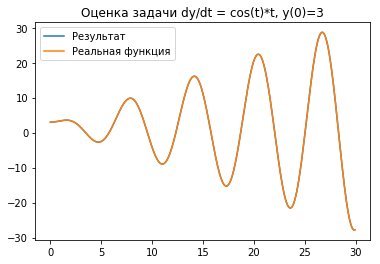

Среднее отклонение результата от истины: 3.528697719592152e-07
Последнее отклонение результата от истины: 9.384378145682604e-07
Среднее относительное отклонение результата от истины: 6.176537906566044e-08
Последнее отклонение результата от истины: 3.375656266400986e-08


In [23]:
test3()
ds = DifSolver(equation=equation, condition=condition)
xs, ys = ds.solve(visualize=False, breadth=30, step=0.1)
ys_true = list(map(true_func, xs))
draw(xs, ys, ys_true, 'Оценка задачи ' + equation+ ', ' + condition)

Как видно, МРК четвёртого порядка хорошо себя показывает.

## Обобщённый метод Рунге-Кутты

Метод РК4 обобщается на произвольный порядок $s$ естественным образом.

$$y_n = y_{n-1} + h\sum\limits_{i=1}^{t}b_ik_i,$$
где $b_i$ --- заданные коэффициенты (*веса*), такие что $\sum b_i = 1$, а $k_i$ являются коэффициентами пересчёта:

$k_1 = f(x_{n-1}, y_{n-1})$,

$k_2 = f(x_{n-1} + c_2h, y_{n-1} + h(a_{21}k_1))$,

$k_3 = f(x_{n-1} + c_3h, y_{n-1} + h(a_{31}k_1 + a_{32}k_2))$,

$\ldots$,

$k_s = f\left(x_{n-1} + c_sh, y_{n-1} + h\left(\sum\limits_{i=1}^{s-1} a_{si}k_i\right)\right)$.

Здесь $a_{ij}$ --- заданная матрица (она называется *матрицей Батчера*), $c_i$ --- заданные коэффициенты (*сдвиги*).

Для наглядности обычно параметры метода изображают в виде таблицы Батчера (матрица Батчера со столбцом из $c_i$ слева и строкой $b_i$ снизу). Параметры $a$ и $c$ берут так, чтобы строки матрицы в сумме давали соответствующие элементы $c$.

На практике замечено, что методы порядка больше $4$ требуют весьма большую вычислительную мощность по сравнению с меньшими.

В класс `DifSolver` параметры метода передаются как параметры `a`, `b`, `c`, соответственно, в функцию `solve()` (детальнее см. описание функции в коде).

## Неявный метод Рунге-Кутты

Эти методы по-прежнему содержат в себе проблему резких перепадов функций-решений. Из-за этого при неудачном выборе $h$ эти перепады могут не попасть в рассматриваемую область $f(x, y)$, из-за чего результирующая оценка в методе будет неправильной.

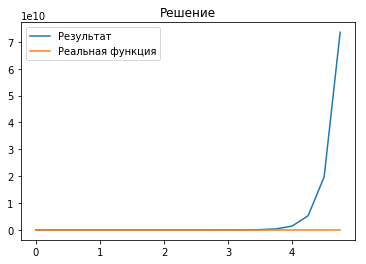

Среднее отклонение результата от истины: 5025485351.122025
Последнее отклонение результата от истины: 73577366321.90662
Среднее относительное отклонение результата от истины: 3.2504355348944784e+40
Последнее отклонение результата от истины: 6.45990414746268e+41


In [20]:
ds = DifSolver(equation='dy/dt = -15*y', condition='y(0)=1')
xs, ys = ds.solve(method='kr4', breadth=5, step=0.25)

ys_true = list(map(lambda x: math.exp(-15*x), xs))
draw(xs, ys, ys_true)

В уравнении $y' = -15y$, например, при использовании метода Эйлера имеем $y(x_n) = y_{n-1} + hf(x_{n-1}, y_{n-1}) = y_{n-1} - 15y(x_{n-1})h = y_{n-1} (1 - 15h)$. Отсюда
$$\frac{y_n}{y_{n-1}} = 1-15h,$$
то есть
$$y_n = (1-15h)^n.$$
Поэтому при недостаточно малых $h$ ($h > \frac1{15}$) последовательность $y_n$ будет расходится.

С этой проблемой хорошо справляются так называемые **неявные методы Рунге-Кутты**.

Принцип у метода тот же, что у явного, но теперь матрица Батчера произвольная, а не нижнетреугольная.

$$y_n = y_{n-1} + h\sum\limits_{i=1}^{t}b_ik_i,$$
где $b_i$ --- заданные коэффициенты (*веса*), такие что $\sum b_i = 1$, а $k_i$ являются коэффициентами пересчёта:


$\forall t \:\: k_t = f\left(x_{n-1} + c_th, y_{n-1} + h\left(\sum\limits_{i=1}^{s-1} a_{ti}k_i\right)\right)$.

$(a_{ij}), c_i$ --- параметры метода.

По сути значения $y_n$ теперь решения уравнения.

Классическими неявными методами являются: 
* неявный метод Эйлера: $a = \begin{pmatrix}1\end{pmatrix}, b = [1], c = [1]$.
* midpoint rule: $a = \begin{pmatrix}\frac12\end{pmatrix}, b = [1], c = \left[\frac12\right]$.
* метод трапеций: $a = \begin{pmatrix}0 & 0\\\frac12 &\frac12 \end{pmatrix}, b = \left[\frac12, \frac12 \right], c = [0, 1]$.

### Неявный метод Эйлера

Простейший неявный метод Рунге-Кутты. Задаётся
$$y_{n+1} = y_n + hf(x_{n+1}, y_{n+1}),$$
или, преобразовав, получаем систему уравнений
$$y_{n+1} = y_n + hk_1, \:\:\: k_1 = f(x_{n+1}, y_n + hk_1).$$
Соответственно, получаем такие параметры неявного метода Рунге-Кутты:

$$a = \begin{pmatrix}1\end{pmatrix},$$ 
$$b = [1],$$
$$c = [1].$$

Иная формулировка:
$$y_{n+1} - hf(x_n, y_{n+1}) - y_n = 0.$$
Необходимо найти корень уравнения. 

Посмотрим на неявный метод Эйлера на нашем примере.

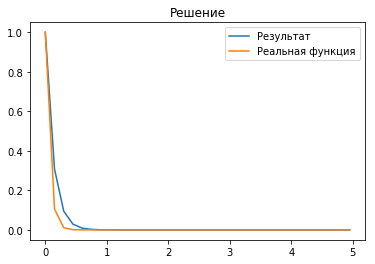

Среднее отклонение результата от истины: 0.009606688062951878
Последнее отклонение результата от истины: 1.2818850650399341e-17
Среднее относительное отклонение результата от истины: 101127915981738.33
Последнее отклонение результата от истины: 2260551309552526.5


In [21]:
ds = DifSolver(equation='dy/dt = -15*y', condition='y(0)=1')
xs, ys = ds.solve(implicit=True, breadth=5, step=0.15)

ys_true = list(map(lambda x: math.exp(-15*x), xs))
draw(xs, ys, ys_true)

Видно, что проблема со сходимостью решена. 

Однако неявные методы обладают недостатком вычислимости: на каждом шаге необходимо решать систему уравнений.

#### Песочница для экспериментов

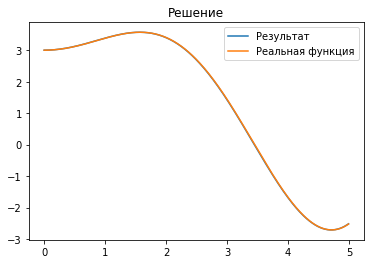

Среднее отклонение результата от истины: 0.00705280720872316
Последнее отклонение результата от истины: 0.006871711798290825
Среднее относительное отклонение результата от истины: 0.9131775826427081
Последнее отклонение результата от истины: 0.002721590234132403


In [22]:
test3()
ds = DifSolver(equation=equation, condition=condition)
xs, ys = ds.solve(implicit=True, breadth=5, step=0.01)
ys_true = list(map(true_func, xs))
draw(xs, ys, ys_true)

*Автор: Константин Матвеев*